# Machine Learning Project Group 8

The following notebook is Group 8's submission to the DAT158 Kaggle contest

##### Group 8:

Jogeir Jonnyson Sætre Liavåg

Jacopo Fidelio

Mirnes Sabaredzovic

## Table of Contents:
* [1. Framing the problem](#first-bullet)
* [2. Get the data](#second-bullet)
* [3. Exploring the data](#third-bullet)
* [4. Preparing the data](#fourth-bullet)
* [5. Exploring different models](#fifth-bullet)
* [6. Fine tuning the model](#sixth-bullet)
* [7. Creating a submission file](#seventh-bullet)
* [8. Launch, monitor and maintaining the system](#eight-bullet)

# 1. Framing the problem <a class="anchor" id="first-bullet"></a>

We are given a collection of data sets to use in our machine learning model that contains Californian census data. This data consists of metrics such as population, median housing price and median income for each block group in California.

<b>Task:</b> Create a machine learning model that can predict median housing price in any district

From the initial data and the task that has been given to us we assume that the intention behind creating this machine learning model is to help determine whether or not it is worth investing in a given area. We therefore make it a high priority that our model can make accurate predictions. If it is not reasonably accurate then it will directly affect the revenue to the company who has given us the task.

As for the models design, the task is typical for supervised learning since we are given training examples that are labeled - meaning that the model can compare its result with the district's median housing price. Since we are trying to predict a value with our model this is also a regression task - more specifically a multiple regression task since we have several features to make a predicted housing price. We are only trying to predict a single value for each district so it will also be a univariate regression problem. Finally we include batch learning in the design because there is no continuous flow of data coming into the system.

# 2. Getting the data <a class="anchor" id="second-bullet"></a>

Starting off with the task at hand, we first retrieve the data from the files included in the Kaggle competition:

In [57]:
import os
print(os.listdir("data"))

['sample_submission.csv', 'submission.csv', 'test.csv', 'train.csv']


We need the files: 'sample_submission.csv', 'test.csv', 'train.csv' in a folder called "data"

In [58]:
import tarfile
import urllib
import pandas as pd
import numpy as np

# Reads in the csv-files and creates a dataframe using pandas
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sampleSubmission = pd.read_csv('data/sample_submission.csv')

# Looking at the data

In [59]:
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.13,37.67,40.0,1748.0,318.0,914.0,317.0,3.8676,184000.0,NEAR BAY
1,-120.98,37.65,40.0,422.0,63.0,158.0,63.0,7.3841,172200.0,INLAND
2,-118.37,33.87,23.0,1829.0,331.0,891.0,356.0,6.5755,359900.0,<1H OCEAN
3,-117.89,33.90,23.0,1533.0,226.0,693.0,230.0,7.8980,258200.0,<1H OCEAN
4,-122.40,37.76,52.0,1529.0,385.0,1347.0,348.0,2.9312,239100.0,NEAR BAY


Every row represents a district and its data spanning from [0...n] where n is the total amount of districts - 1 (given Pythons indexing of values in an array starting at 0). We can also get additional info by doing:

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


We see now that the data set contains 16512 entries meaning that 16512 Californian districts are represented with its data which we can use in our model. The size is small though compared to what is standard to machine learning. Another thing to note is that there are 16512 entries but 'only' 16344 of them have a non-null value for total_bedrooms which we must remember to fix later in the process.


We can also do the same for the test data:

In [61]:
test.head()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,0,-122.27,37.87,35.0,3218.0,1108.0,1675.0,1000.0,1.7464,NEAR BAY
1,1,-118.94,34.18,24.0,3689.0,585.0,1898.0,581.0,5.9224,<1H OCEAN
2,2,-119.75,36.77,32.0,1962.0,399.0,1005.0,392.0,2.6726,INLAND
3,3,-118.34,33.93,32.0,1254.0,399.0,1281.0,386.0,2.2976,<1H OCEAN
4,4,-119.00,35.36,35.0,1021.0,280.0,1258.0,239.0,1.7375,INLAND


In [62]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4128 entries, 0 to 4127
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  4128 non-null   int64  
 1   longitude           4128 non-null   float64
 2   latitude            4128 non-null   float64
 3   housing_median_age  4128 non-null   float64
 4   total_rooms         4128 non-null   float64
 5   total_bedrooms      4089 non-null   float64
 6   population          4128 non-null   float64
 7   households          4128 non-null   float64
 8   median_income       4128 non-null   float64
 9   ocean_proximity     4128 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 322.6+ KB


We can also get a summary of the numerical attributes by doing:

In [63]:
train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.568763,35.630270,28.714571,2636.885841,537.999755,1425.131783,499.837936,3.871083,207262.390080
std,2.003747,2.137134,12.589203,2195.840228,422.944167,1126.453504,383.400473,1.909994,115838.329585
min,-124.350000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1445.000000,295.000000,787.000000,279.000000,2.562500,120000.000000
50%,-118.490000,34.260000,29.000000,2122.500000,434.000000,1163.000000,409.000000,3.529450,180400.000000
75%,-118.010000,37.710000,37.000000,3137.000000,646.000000,1723.000000,603.000000,4.746450,265100.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


In [64]:
test.describe()

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4089.000000,4128.000000,4128.000000,4128.000000
mean,2063.500000,-119.573469,35.638227,28.339147,2631.272045,537.354121,1426.856589,498.346657,3.869022
std,1191.795284,2.002909,2.131467,12.568004,2124.017670,415.145532,1156.321987,378.060252,1.858802
min,0.000000,-124.210000,32.550000,1.000000,2.000000,2.000000,6.000000,2.000000,0.499900
25%,1031.750000,-121.800000,33.930000,18.000000,1463.000000,299.000000,787.750000,283.000000,2.568725
50%,2063.500000,-118.530000,34.250000,28.000000,2148.000000,437.000000,1181.000000,411.000000,3.554900
75%,3095.250000,-118.007500,37.720000,37.000000,3185.500000,650.000000,1737.250000,610.000000,4.731425
max,4127.000000,-114.490000,41.860000,52.000000,32627.000000,6445.000000,28566.000000,6082.000000,15.000100




To get an even better graphical representation of the data we can make use of the hist() method from Matplotlib. This should help identify things about the data that might require our attention later on.


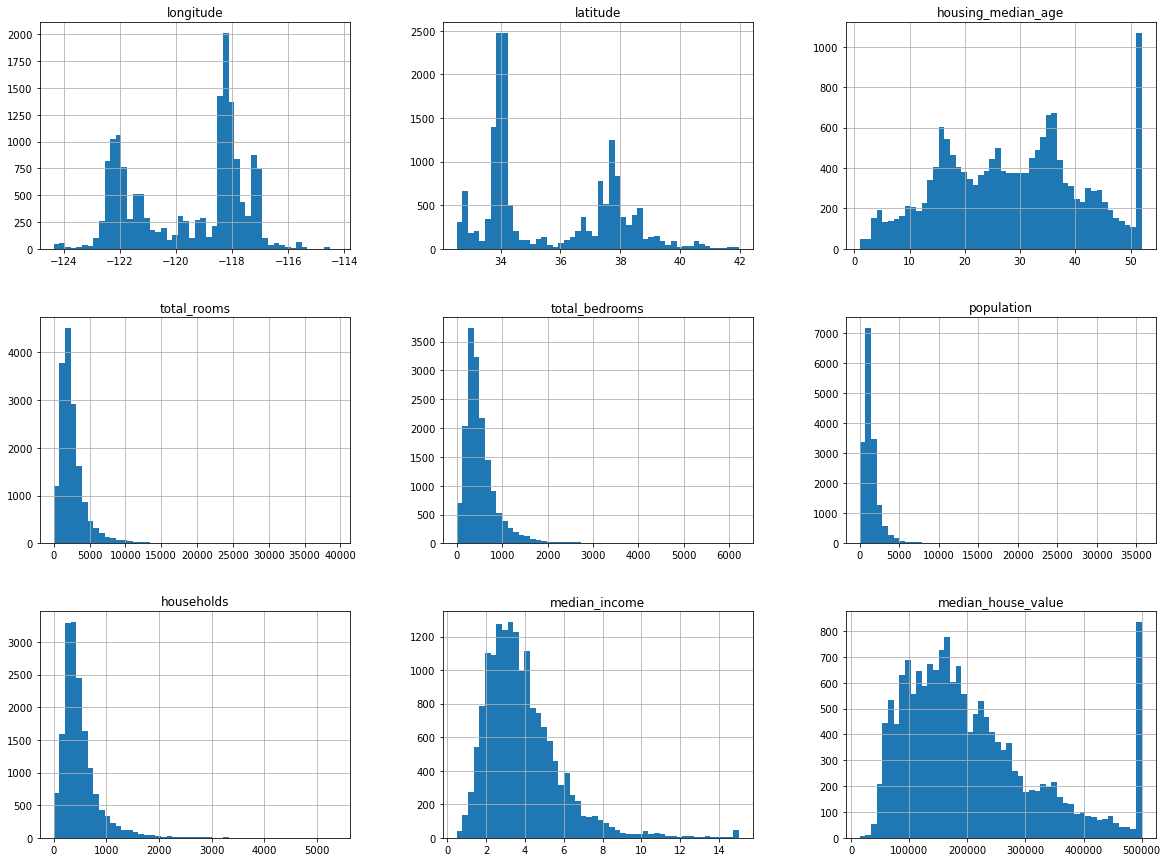

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()

Looking at the histogram, we can spot something unusual looking. The "median_house_value" is capped at 500k, and "housing_median_age" is capped at 50 years. 

# 3. Exploring the data <a class="anchor" id="third-bullet"></a>

Before we start digging into the data we should make a seperate copy to do the work on so we do not risk harming the training set.

In [66]:
housing = train.copy()

First thing we want to visualize is the geographical data (longitude and latitude) to see if certain areas have higher housing prices:

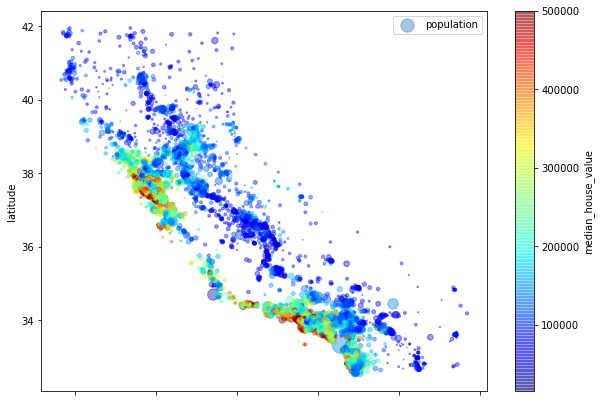

In [67]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

As we can see from the graph, there seems to be a relation between the location of the house (in a highly desired location like Los Angeles for example and/or close to the ocean) and the density of the population.

We can also check how much impact each attribute has on the median_house_value by making use of the corr() method:

In [68]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.684828
total_rooms           0.133566
housing_median_age    0.107684
households            0.065778
total_bedrooms        0.049941
population           -0.025008
longitude            -0.043824
latitude             -0.146748
Name: median_house_value, dtype: float64

The values ranges from 1 to -1 and the closer the value is to 1 the bigger impact that attribute has on the median_house_value. By quickly looking at the values we got from the corr() method we can see that obviously the median_income attribute has the biggest impact on the median_house_value attribute.

We can make further use out of this by plotting the attributes that seem most correlated in a pandas scatter plot

The attributes we select is:
<ul><b>
    <li>median_house_value</li>
    <li>median_income</li>
    <li>total_rooms</li>
    <li>housing_median_age</li>
    </b></ul>

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

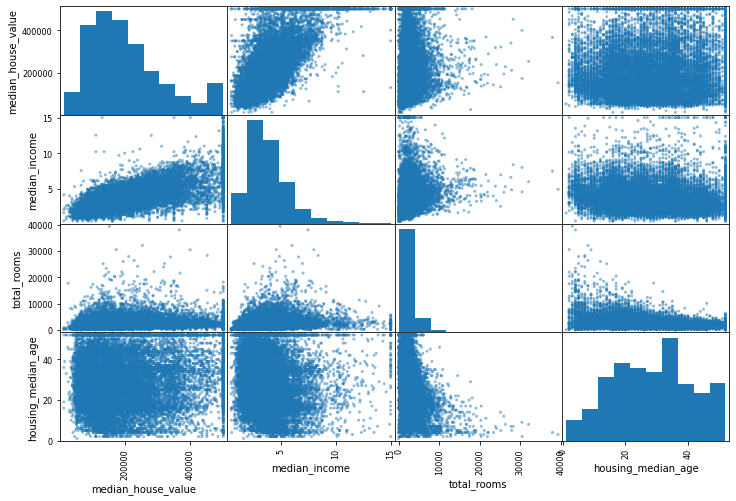

In [69]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

In this plot every numerical attribute is plotted against every other numerical attribute with a histogram for each matching. This shows the correlation in a more graphical way instead of just numbers from 1 to -1. From the first correlation check we now know that median_house_value and median_income is most related to each other so lets zoom in on that plot here: 

In [70]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     7346
INLAND        5214
NEAR OCEAN    2112
NEAR BAY      1835
ISLAND           5
Name: ocean_proximity, dtype: int64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

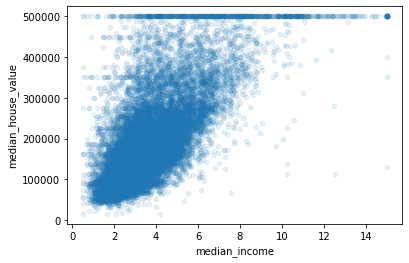

In [71]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)


Again we get confirmed that there is a strong correlation between the two attributes since there is an upward trend with the points not being too spread from each other. There also seems to be some quirks with what appears to be horizontal lines at the 450.000 and 350.000 mark that might have to be removed to prevent the model from reproducing these quirks.

Looking again at the total_rooms, total_bedrooms, households and population attributes they do not seem that useful just on their own. Therefore a good idea is to make combinations of these that might reveal new correlations. We put total_rooms up against households to find the number of rooms per household,  the total_rooms up against total_bedrooms and population up against households to find population per household:

### Experimenting with Attribute Combinations

In [72]:
housing_expertimental = housing.copy()

housing_expertimental["rooms_per_household"] = housing_expertimental["total_rooms"]/housing_expertimental["households"]
housing_expertimental["bedrooms_per_room"] = housing_expertimental["total_bedrooms"]/housing_expertimental["total_rooms"]
housing_expertimental["population_per_household"]=housing_expertimental["population"]/housing_expertimental["households"]


corr_matrix = housing_expertimental.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.684828
rooms_per_household         0.171947
total_rooms                 0.133566
housing_median_age          0.107684
households                  0.065778
total_bedrooms              0.049941
population                 -0.025008
population_per_household   -0.026596
longitude                  -0.043824
latitude                   -0.146748
bedrooms_per_room          -0.256396
Name: median_house_value, dtype: float64

By making these combinations of attributes we learned some new things from the data:

<ul>
    <li>The more rooms in the average house of a district - the higher the value</li>
    <li>Houses with a lower bedroom/room ratio tend to be more expensive
</ul>

Some of this new data might be self explanatory, but it is nice to get a confirmation that the correlation is there.

# 4. Prepare the Data for Machine Learning Algorithms <a class="anchor" id="fourth-bullet"></a>

## Data Cleaning

Removing districts with median_house_value more than 499999 to clean up the data, since the histrograms showed that the data was weird/unnatural because of a cap of 500k. Also cleaning up the lines at 450k and 350k. Lose 910 instances of data by doing this.

Removing districts with housing_median_age more than 49 to clean up weird data due to cap of 50. Lose 992 instances by doing this.

16512 - 910 - 992  = 14610

In [73]:
housing = housing.query("housing_median_age < 50")
housing = housing.query("median_house_value < 500000")
housing = housing.query("median_house_value != 450000")
housing = housing.query("median_house_value != 350000")
len(housing)


14610

Lets look at the histogram again now that we've cleaned up some data

array([[<AxesSubplot:title={'center':'housing_median_age'}>,
        <AxesSubplot:title={'center':'median_income'}>]], dtype=object)

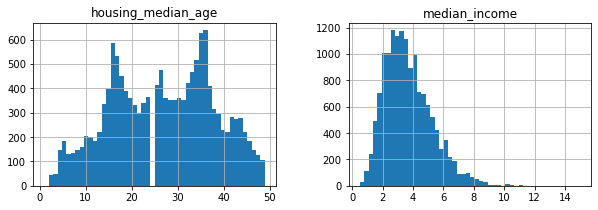

In [74]:
housing.hist(["housing_median_age", "median_income"], bins=50, figsize=(10,3))

Much better! Although there is a weird line at housing_median_age=25 that we can't explain.

Lets look at the graph of median income to better spot the lines.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

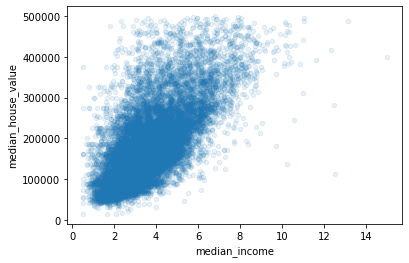

In [75]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This looks alot better

Lets split the labels from the rest of the data.

In [76]:
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)

Now we can copy it into a variable signaling that the data is clean.

In [77]:
cleaned_test = test.copy()
# The Id column also needs to be dropped because it has no use for us
cleaned_test = cleaned_test.drop(columns=['Id'])

### Dealing with missing values

We need handle any value that might missing in the dataset. We only have one attribute with missing values, total_bedrooms. We are missing 168 entries out of 16512.

We can either:
1. Get rid of the instances with missing total_bedrooms
2. Drop the whole attribute entirely, or 
3. Put in some value where its missing (zero, the mean, the median, etc.)




* The dataset is already small, so we don't want to remove instances without a very good reason.
* We definitly don't want to drop the entire attribute, since the created attribute "bedrooms_per_room" seems very useful and is our second best correlation to median_house_value.

We will choose a middle-ground approach and fill the values with median, by using a library for imputting missing values.

We cannot calculate median for text attributes, so we need to temporarily split the text attributes ("ocean_proximity") and the rest of the attributes.

In [78]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Splitting text attributes from number attributes
housing_num = housing.drop("ocean_proximity", axis=1)

# This calculates the median values for each column
imputer.fit(housing_num)

# This fills inn the median values where values are missing, and we store it into an variable called X
X = imputer.transform(housing_num)

In [79]:
# Putting it back into a pandas dataframe with missing values filled
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [80]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14610 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14610 non-null  float64
 1   latitude            14610 non-null  float64
 2   housing_median_age  14610 non-null  float64
 3   total_rooms         14610 non-null  float64
 4   total_bedrooms      14610 non-null  float64
 5   population          14610 non-null  float64
 6   households          14610 non-null  float64
 7   median_income       14610 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


No more missing values!

### Handling Text and Categorical Attributes

Next we should get rid of text and categorical attributes since machine learning prefers to work with numbers. One instance of this is the ocean_proximity attribute:

In [81]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,INLAND
2,<1H OCEAN
3,<1H OCEAN
5,<1H OCEAN
6,INLAND
7,NEAR BAY
8,INLAND
9,INLAND
11,INLAND


Again we see that we have different values for ocean_proximity. As it turns out, only inland is really useful, so let's transform all other categories into "NOTINLAND"

In [82]:
from sklearn.preprocessing import OrdinalEncoder

# Used for transforming all ocean_proximities other than INLAND to NOTINLAND
def ocean_cleaner(housing_cat):
    housing_cat = housing_cat.replace("<1H OCEAN", "NOTINLAND")
    housing_cat = housing_cat.replace("ISLAND", "NOTINLAND")
    housing_cat = housing_cat.replace("NEAR BAY", "NOTINLAND")
    housing_cat = housing_cat.replace("NEAR OCEAN", "NOTINLAND")
    return housing_cat


housing = ocean_cleaner(housing)

Lets look at the values for ocean_proximity again after running ocean_cleaner

In [83]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NOTINLAND
1,INLAND
2,NOTINLAND
3,NOTINLAND
5,NOTINLAND
6,INLAND
7,NOTINLAND
8,INLAND
9,INLAND
11,INLAND


Perfect! Now let's fix the ocean_proximity for the test set:

In [84]:
# Need to add these categories to avoid 
# F"Number of features of the input must be equal to or greater than that of the fitted transformer. Transformer n_features is 12 and input n_features is 9."

#cleaned_test["rooms_per_household"] = cleaned_test["total_rooms"]/housing["households"]
#cleaned_test["bedrooms_per_room"] = cleaned_test["total_bedrooms"]/housing["total_rooms"]
#cleaned_test["population_per_household"]= cleaned_test["population"]/housing["households"]

# Need to add these categories to avoid 
# "ValueError: Found unknown categories ['NEAR BAY', 'NEAR OCEAN', '<1H OCEAN'] in column 0 during transform"
cleaned_test = ocean_cleaner(cleaned_test)

But we still can't run this text through our models. We need to transform them into numbers. We can use OrdinalEncoder for that, and assign numbers to each textvalue.

In [85]:
from sklearn.preprocessing import OrdinalEncoder
housing_cat = housing[["ocean_proximity"]]

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]])

Now they will work in our models.

### Custom Transformers

Next step is to setup a custom transformer that we can use in our pipeline
We will create a pipeline that automatically created the new attributes we explored:

In [86]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix  = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
train_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling & Transformation Pipelines

Since out data uses different sizes for the values (values may be 0-15 or 35000 is some cases), we need to scale it properly.
We can use normalization or standardization.

We choose standardization because we're not using neural networks so we don't need the values to be ranging from 0 to 1, and standardization work better with outliers.

We use sklearn.preprocessing's StandardScaler


Lets throw together the median imputter, our own transformer and the stabdardscaler into one pipeline:

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Since we have both numbers and categories, we setup a ColumnTransformer that can handle both types

In [88]:
from sklearn.compose import ColumnTransformer

#housing = clean_cat(housing)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]


full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OrdinalEncoder(), cat_attribs)
 ])
    
housing_prepared = full_pipeline.fit_transform(housing)

Let us have a look at the ready data that can be sent into our model:

In [89]:
housing_prepared

array([[-1.33913632,  0.96729857,  1.16803764, ..., -0.0196225 ,
        -0.5474246 ,  1.        ],
       [-0.75846768,  0.95799768,  1.16803764, ..., -0.05246418,
        -1.10334422,  0.        ],
       [ 0.55939768, -0.79986988, -0.33921537, ..., -0.05291283,
        -0.56359103,  1.        ],
       ...,
       [ 0.90274957, -0.93473274, -1.93513033, ..., -0.01555785,
        -1.06750958,  1.        ],
       [ 1.09967198, -0.69290968,  1.96599512, ...,  0.23962147,
        -0.52338525,  0.        ],
       [-1.15736179,  1.11611276, -2.02379227, ...,  0.02492924,
        -1.28346198,  0.        ]])

# 5. Exploring different models <a class="anchor" id="fifth-bullet"></a>

In [90]:
# Helper Method
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

To begin with we define a <b>Linear Regression</b> model and see how that performs in making predictions in relation to our data:

### Linear Regression

In [91]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

We try out the model on a few instances from the training set:

In [92]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [223312.12184983 295354.05180127 318078.86581411 349418.67228303
 233643.46733401]


In [93]:
print("Labels:", list(some_labels))

Labels: [184000.0, 172200.0, 359900.0, 258200.0, 174600.0]


It "works" but the predictions we get from the model is not nearly as accurate as we need them to be. Let's see how it does on the whole training set with the mean_squared_error() function:

In [94]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

56743.987206039485

In [95]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

Let us try Decision Trees:

### Tree Rmse

In [96]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

Applying the Decision Tree on the training set:

In [97]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

With a result of 0.0 the data has most likely been overfit, so we make use of cross-validation feature of K-fold:

In [98]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [59445.88826046 62857.51177424 59916.71746825 63249.82592169
 57672.95186774 58840.36048413 60814.03484803 59556.417038
 62242.49276125 65149.137285  ]
Mean: 60974.533770879105
Standard deviation: 2206.9273008865384


We then take another look at the results:

In [99]:
display_scores(tree_rmse_scores)

Scores: [59445.88826046 62857.51177424 59916.71746825 63249.82592169
 57672.95186774 58840.36048413 60814.03484803 59556.417038
 62242.49276125 65149.137285  ]
Mean: 60974.533770879105
Standard deviation: 2206.9273008865384


### Lin Rmse

In [100]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
 scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [57760.97153668 54977.52587601 59672.15877118 55319.78998434
 55620.62213634 53779.51154351 55070.42171326 56388.10813576
 60368.72898788 60552.33069801]
Mean: 56951.016938296976
Standard deviation: 2344.10592001932


The Decision Tree model performs worse than the Linear Regression model so there is no use of the model here unfortunately...

Next up could be a <b>RandomForestRegressor</b>:

### Forest Rmse

In [101]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

train_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [43227.61929186 41549.59432383 41105.70211935 43163.41920758
 43078.17548682 41674.75399972 41856.61665345 42081.14896379
 45705.86619207 45441.74875314]
Mean: 42888.4644991627
Standard deviation: 1511.4233583210873


A much better result - Random Forests looks like the best option right now to use for our machine learning model.

# 6. Fine tuning the model <a class="anchor" id="sixth-bullet"></a>

Now for the fine tuning of the Random Forest model that looked the most promising in the last section.

First we can make use of the GridSearchCV method that allows us to look for optimized hyperparameters:

In [102]:
from sklearn.model_selection import GridSearchCV

# {'n_estimators': [3, 10, 100, 500, 700, 1000], 'max_features': [2, 4, 5, 6, 8]},
# {'bootstrap': [False], 'n_estimators': [3, 10, 100, 500, 700, 1000], 'max_features': [2, 4, 5, 6, 8]},

param_grid = [
 {'bootstrap': [False], 'n_estimators': [700], 'max_features': [5]},
 ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error',
 return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False], 'max_features': [5],
                          'n_estimators': [700]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Then we call grid_search.best_params_ to find out which parameters gave the best result:

In [103]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 5, 'n_estimators': 700}

We can also just call grid_search.best_estimator_

In [104]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=5, n_estimators=700)

The results from the grid search can also be made more viewable by merging the test score along with the params that achieved the score:

In [105]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

42216.441105917605 {'bootstrap': False, 'max_features': 5, 'n_estimators': 700}


42152.56173510882 {'bootstrap': False, 'max_features': 5, 'n_estimators': 700} seems like a very good fine tuning of the Random Forest model.

Now lets take a look at which features impact the median_house_value the most with the best parameters we just found:

In [106]:
def remove_useless_attribs(housingNumWithoutUselessCats):
    housingNumWithoutUselessCats = housingNumWithoutUselessCats.drop("ocean_proximity", axis=1)
    housingNumWithoutUselessCats = housingNumWithoutUselessCats.drop("total_rooms", axis=1)
    housingNumWithoutUselessCats = housingNumWithoutUselessCats.drop("population", axis=1)
    housingNumWithoutUselessCats = housingNumWithoutUselessCats.drop("total_bedrooms", axis=1)
    housingNumWithoutUselessCats = housingNumWithoutUselessCats.drop("households", axis=1)
    return housingNumWithoutUselessCats

feature_importances = grid_search.best_estimator_.feature_importances_


extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = ["INLAND", "NOTINLAND"]
num_attribs = list(remove_useless_attribs(housing))
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.3258276432378467, 'INLAND'),
 (0.08866779174271784, 'longitude'),
 (0.08465727023023643, 'latitude'),
 (0.048978114403060664, 'NOTINLAND'),
 (0.037884948628197634, 'housing_median_age'),
 (0.018130300683087006, 'median_income'),
 (0.017562381064648414, 'pop_per_hhold'),
 (0.017005422999566935, 'rooms_per_hhold'),
 (0.01644293777746173, 'bedrooms_per_room')]

Median_income and INLAND shows as the most impactful features to the median_house_value.

In [107]:
#final_model = grid_search.best_estimator_

#_test = strat_test_set.drop("median_house_value", axis=1)
#_test = strat_test_set["median_house_value"].copy()

#_test_prepared = full_pipeline.transform(X_test)

#inal_predictions = final_model.predict(X_test_prepared)

#inal_mse = mean_squared_error(y_test, final_predictions)
#inal_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2

In [108]:
#from scipy import stats
#confidence = 0.95
#squared_errors = (final_predictions - y_test) ** 2
#np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
# loc=squared_errors.mean(),
# scale=stats.sem(squared_errors)))


# Testing the fine-tuned system

With our system now fine-tuned in terms of performance we can now set it loose on the test set we have kept in the background all this time. We did some cleanup on it in an earlier section and we can quickly have a look at its current state:


In [109]:
cleaned_test.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.27,37.87,35.0,3218.0,1108.0,1675.0,1000.0,1.7464,NOTINLAND
1,-118.94,34.18,24.0,3689.0,585.0,1898.0,581.0,5.9224,NOTINLAND
2,-119.75,36.77,32.0,1962.0,399.0,1005.0,392.0,2.6726,INLAND
3,-118.34,33.93,32.0,1254.0,399.0,1281.0,386.0,2.2976,NOTINLAND
4,-119.00,35.36,35.0,1021.0,280.0,1258.0,239.0,1.7375,INLAND


Now we compare this with the data we have tested in the pipeline beforehand which worked:

In [110]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.13,37.67,40.0,1748.0,318.0,914.0,317.0,3.8676,NOTINLAND
1,-120.98,37.65,40.0,422.0,63.0,158.0,63.0,7.3841,INLAND
2,-118.37,33.87,23.0,1829.0,331.0,891.0,356.0,6.5755,NOTINLAND
3,-117.89,33.90,23.0,1533.0,226.0,693.0,230.0,7.8980,NOTINLAND
5,-118.10,33.90,40.0,1880.0,377.0,1229.0,378.0,4.4167,NOTINLAND


Looks ready! Now we only take out the fine-tuned model we found in the last chapter, send the test data into the pipeline and we predict the median_house_value with the model we have made:

In [111]:
final_model = grid_search.best_estimator_

X_test_prepared = full_pipeline.transform(cleaned_test)

median_house_value = final_model.predict(X_test_prepared)

Quick check to see if our median_house_value has the correct amount of values for the Kaggle contest (4128 required):

In [112]:
len(median_house_value)

4128

Having a look at the first 10 values as well would be a good idea:

In [113]:
median_house_value[:10]

array([202073.14285714, 247778.        ,  72431.42857143, 172164.28571429,
        48021.57142857, 253489.42857143, 105181.28571429, 104201.14285714,
       144221.71428571,  78005.42857143])

# 7. Presenting solution and creating a submission file <a class="anchor" id="seventh-bullet"></a>

Now that the model works and have made a prediction that has been submitted to the Kaggle contest it is time to take a step back and make some thoughts about how we did compared to the task we outlined at the start.

As of the latest result we have a model that predicts district house prices with an error of about 42,220 dollars on Kaggle. This is a considerable jump from the Linear Regression model we started out with so we have made some progress.

There are most likely still improvements though that can be made in certain areas with an entirly different model or combination of models (ensemble learning) or correlations that we have not caught up that could have improved the performance of our model.

Unfortunatly, having an error of 42k dollars makes the model useless. More data-cleaning need to be done, and we need better features to get to a realistically usable point.

### Creating submission file for Kaggle

Now we simply feed the median_house_value variable into a DataFrame along with an Id for each value's index since these are the requirements for the Kaggle competition submission files:

In [114]:
submission = pd.DataFrame({
    'Id': [i for i in range(len(median_house_value))],
    'median_house_value': median_house_value.flatten()
})

A quick look at the DataFrame to make sure everything is in order:

In [115]:
submission.head()

,Id,median_house_value
0,0,202073.142857
1,1,247778.000000
2,2,72431.428571
3,3,172164.285714
4,4,48021.571429


Now we convert the results into a csv file which we can upload to the Kaggle competition:

In [116]:
# Converts the submission variable into a csv file to submit to the kaggle competition
submission.to_csv('submission.csv', index=False)

# 8.  Launch, monitor and maintaining the system <a class="anchor" id="eight-bullet"></a>

Assuming our resulting prediction model is approved by our employer, it is now time to launch the system. Getting it ready for production we have to do some additional steps like writing documentation, tests and polishing the code and more. After that is done we can deploy the model to our production enviroment.

One way of doing this is to save the trained model by using joblib for example, which includes all the preprocessing and prediction pipeline, then load the trained model within our production enviroment and use it to make predictions by using the function call predict().

As for the deployment of the service we can go for a traditional web service where users (in this case realty investors) can send requests to a website where its contents will be put into our predict() function then sent back again to the user with the result. If simplicity is more preferred another popular strategy is to make use of the Google Cloud AI platform. There we simply upload our saved model to the Google Cloud Storage then head over to the AI platform and create a new model which points to the stored model. The requests and reponses are entirely in JSON format and takes care of load balancing and scaling for us.

Now with the model launched we have to consider monitoring and maintenance. Machine learning models tends to "rot" over time so implementing a monitoring system to give alerts when the model "goes bad" would be a good idea. The monitoring system should be able to define what to do in case of failures and how to prepare for them. In regards to maintenance, we have to update our datasets and retrain our models regularly. The census data we have now might not be as relevant a year or two down the line when prices evolves so fetching new data and training a new model in regular intervals is a good idea to keep the predictions accurate. This entire process should be automated as much as possible through the use of scripts since they will require the same steps each time. 

Finally, keeping backups of the older models as you update them is also a good idea incase the new model for some reason performs badly or in some other unexpected way. It can also be useful if you want to compare the performance of new models with the older ones.